# Arbeidskrav 5 - Nettskraping, datavask og lineær regresjonsmodell

In [34]:
# importerer pakker. 
from bs4 import BeautifulSoup
import requests
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

### 1) Skap nettsiden og lagre resultatene i en dataramme.
##### Hint: argumentet "on_bad_lines='skip'" kan være nyttig når du skal laste opp csv-filen

In [3]:
# Benytter meg av samme metode som "9 - webskraping med python"
def fetch_html_tables(url):
    "Returns a list of tables in the html of url"
    page = requests.get(url)
    bs=BeautifulSoup(page.content)
    tables=bs.find_all('table')
    return tables

tables=fetch_html_tables('https://www.motor.no/aktuelt/motors-store-vintertest-av-rekkevidde-pa-elbiler/217132')
table_html=tables[0]

In [4]:
def html_to_table(html):
    "Returns the table defined in html as a list"
    #defining the table:
    table=[]
    #iterating over all rows
    for row in html.find_all('tr'):
        r=[]
        #finding all cells in each row:
        cells=row.find_all('td')
        
        #if no cells are found, look for headings
        if len(cells)==0:
            cells=row.find_all('th')
            
        #iterate over cells:
        for cell in cells:
            cell=format(cell)
            r.append(cell)
        
        #append the row to t:
        table.append(r)
    return table

def format(cell):
    "Returns a string after converting bs4 object cell to clean text"
    if cell.content is None:
        s=cell.text
    elif len(cell.content)==0:
        return ''
    else:
        s=' '.join([str(c) for c in cell.content])
        
    #here you can add additional characters/strings you want to 
    #remove, change punctuations or format the string in other
    #ways:
    s=s.replace('\xa0','')
    s=s.replace('\n','')
    return s

table=html_to_table(table_html)


';'.join(table[0])

'                Modell (temp. varierte fra 0° til -10°)                ;                WLTP-tall                ;                STOPP                ;                Avvik                '

In [5]:
def save_data(file_name,table):
    "Saves table to file_name"
    f=open(file_name,'w')
    for row in table:
        f.write(';'.join(row)+'\n')
    f.close()
    
save_data('wintertest.csv',table)

In [6]:
car = pd.read_csv('wintertest.csv', delimiter=';')

# lager nye navn på kolonnene. 
car.columns = ['modell', 'wltp', 'stopp', 'avvik']

### 2) Vask dataen til en tabell med bare relevante tall og gode overskrifter.
##### Her er det mange veier til Rom, men en måte å gå frem på kan være følgende:
##### - Del kolonnen med WLTP-tall i to: en for kjørte km og en for energibruk.
###### Hint: metodene "str.split()" og "drop()" kan være nyttige her.
##### - Fjern benevninger i alle kolonnene med relevante tall.
###### Hint: kommandoen "str.replace()" kan være nnyttig her.
##### - Noen rader i datarammen inneholder ikke gyldige verdier (Polestar og Hyundai), og bør fjernes. Det kan gjøres med å sørge for at alle tallene faktisk er positive av typen "float".

In [7]:
# skiller mellom km og kWh i nye kolonner. 
car[['km', 'kWh']] = car.wltp.str.split("/", expand = True)

# Skiller tall og tekst. 
car[['Km', 'text1']] = car['km'].str.split(' ', expand = True)

# Skiller tall og tekst
car[['Stopp', 'text3']] = car['stopp'].str.split(' ', expand = True)

In [8]:
# Kopierer df med de kolonnene jeg trenger. 
car_new = car[['modell', 'Km', 'Stopp']].copy()

In [9]:
# Fjerner rader med "x". 
car_new = car_new[car_new["Stopp"].str.contains("x") == False]

In [10]:
# Endrer dtype til str og int. 
car_new['modell'] = car_new['modell'].astype(str)

# Endrer dtype til int. 
car_new['Km'] = car_new['Km'].astype(str).astype(int)

# Endrer dtype til int. 
car_new['Stopp'] = car_new['Stopp'].astype(str).astype(int)

### 3) Regresjonsmodell
##### Lag en regresjonsmodell av typen f(x) = ax + b der WLTP-km er uavhengig variabel, og plott modellen mot leverandørens påståtte kjørelengde. Resultatet skal bli som i figuren under, men din kode skal inkludere origo i plottet

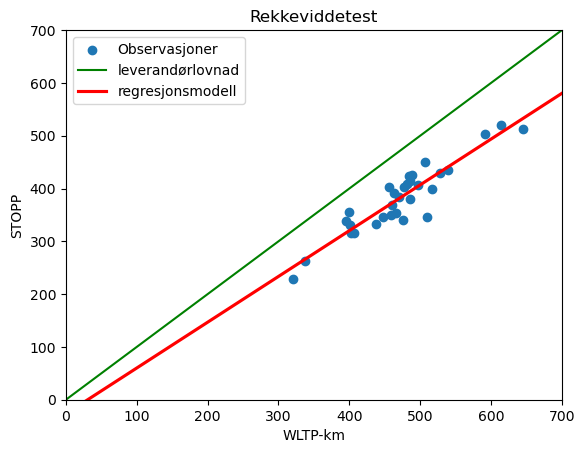

In [85]:
# Setter linspace. 
x = np.linspace(0,700,100)

# Lagrer figur som "fig".  
fig, ax = plt.subplots()

# Bestemmer lengden på x og y-aksen. 
xlim = [0,700]
ax.set_xlim(xlim)
ylim = [0,700]
ax.set_ylim(ylim)

# Scatter med 'km' og 'stopp'. 
ax.scatter(car_new['Km'], car_new['Stopp'], label = 'Observasjoner')

# Tegner inn en 45 graders linje. 
ax.axline([0,0], [1,1], color = "green", label = "leverandørlovnad")

# plot hentet fra -> https://towardsdatascience.com/regression-plots-in-python-with-seaborn-118472b12e3d
# parameter hentet fra -> https://seaborn.pydata.org/generated/seaborn.regplot.html 
sns.regplot(x = 'Km', y = 'Stopp', data=car_new, truncate = False, ci = None, scatter = False, color = "red", label = "regresjonsmodell")

# Tittel og navn på aksene.  
ax.set_title('Rekkeviddetest')
ax.set_ylabel('STOPP', loc='center')
ax.set_xlabel('WLTP-km', loc='center')

# Legend. 
ax.legend(loc='upper left');